原始数据行数: 582100
处理后数据行数: 806


D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\python\version\Lib\site-packages\statsmodels\tsa\states

总获利金额: 1063413.00
交易次数: 40
胜率: 56.41%
平均盈利: 756.09
平均亏损: -679.24
盈亏比: 1.11


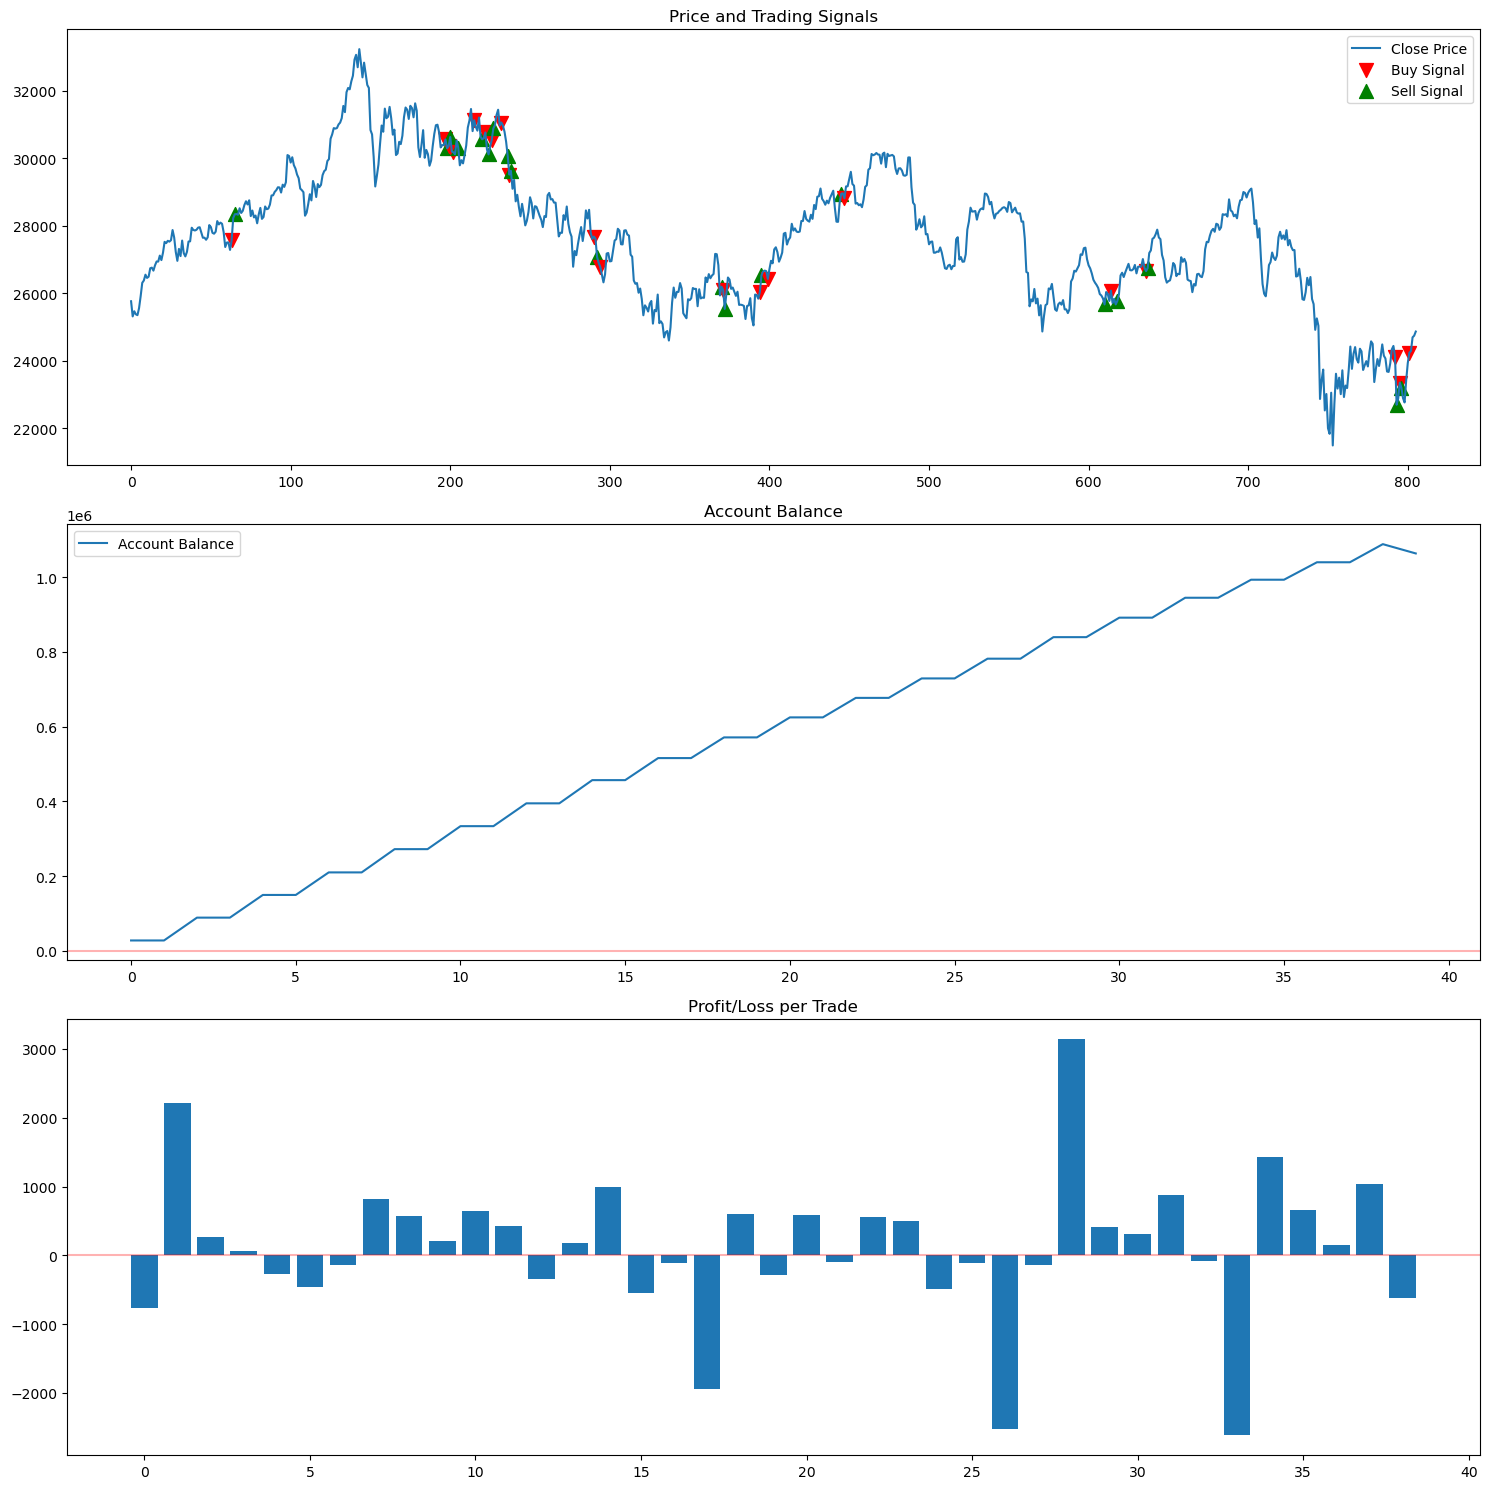

交易记录已保存至 trading_results.csv


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 读取数据并只保留每日最后一分钟的交易数据
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    # 按日期分组并获取每组的最后一行（每天的最后一分钟）
    last_minute_df = df.groupby('date').last().reset_index()
    
    print(f"原始数据行数: {len(df)}")
    print(f"处理后数据行数: {len(last_minute_df)}")
    
    return last_minute_df

# 迪基-富勒检验函数
def is_stationary(series, significance=0.05):
    result = adfuller(series)
    p_value = result[1]
    return p_value < significance  # 如果p值小于显著性水平，则拒绝原假设，认为序列是平稳的

# 交易策略实现
def arima_adf_strategy(df):
    # 初始化结果
    trades = []
    balance = 0  # 仅用于跟踪交易
    positions = []  # 1表示多头，-1表示空头，0表示无持仓
    current_position = 0
    
    # 从第61行开始（前60天用于建模）
    for i in range(60, len(df)):
        # 获取过去60天的收盘价
        past_60_close = df['hi1_close'].iloc[i-60:i].values
        current_price = df['hi1_close'].iloc[i]
        current_date = df['date'].iloc[i]
        current_time = df['time'].iloc[i]
        
        # 检查是否平稳
        if is_stationary(past_60_close):
            try:
                # 构建ARIMA(1,1,1)模型
                model = ARIMA(past_60_close, order=(1, 1, 1))
                model_fit = model.fit()
                
                # 预测下一个值
                forecast = model_fit.forecast(steps=1)[0]
                price_change_prediction = forecast - past_60_close[-1]
                
                # 交易决策
                if price_change_prediction > 0:  # 预测价格上涨
                    if current_position != 1:  # 如果当前不是多头
                        # 平掉旧仓位（如果有）
                        if current_position == -1:
                            profit = current_price  # 平空头的收益
                            balance += profit
                        
                        # 开新仓位
                        balance -= current_price  # 买入
                        current_position = 1
                        trades.append({
                            'date': current_date,
                            'time': current_time,
                            'action': 'BUY',
                            'price': current_price,
                            'balance': balance
                        })
                
                elif price_change_prediction < 0:  # 预测价格下跌
                    if current_position != -1:  # 如果当前不是空头
                        # 平掉旧仓位（如果有）
                        if current_position == 1:
                            profit = current_price  # 平多头的收益
                            balance += profit
                        
                        # 开新仓位
                        balance += current_price  # 卖出
                        current_position = -1
                        trades.append({
                            'date': current_date,
                            'time': current_time,
                            'action': 'SELL',
                            'price': current_price,
                            'balance': balance
                        })
            
            except Exception as e:
                # 如果ARIMA模型拟合失败，不进行交易
                print(f"ARIMA模型拟合失败: {e}")
                pass
        
        positions.append(current_position)
    
    # 平掉最后的持仓
    final_price = df['hi1_close'].iloc[-1]
    final_date = df['date'].iloc[-1]
    final_time = df['time'].iloc[-1]
    
    if current_position == 1:
        profit = final_price
        balance += profit
        trades.append({
            'date': final_date,
            'time': final_time,
            'action': 'CLOSE_LONG',
            'price': final_price,
            'balance': balance
        })
    elif current_position == -1:
        profit = -final_price
        balance += profit
        trades.append({
            'date': final_date,
            'time': final_time,
            'action': 'CLOSE_SHORT',
            'price': final_price,
            'balance': balance
        })
    
    # 计算策略表现
    trade_df = pd.DataFrame(trades)
    
    # 计算总收益
    total_profit = balance
    
    # 计算交易次数
    num_trades = len(trades)
    
    # 计算每笔交易的盈亏
    trade_profits = []
    if num_trades > 0:
        for i in range(1, len(trades)):
            if trades[i-1]['action'] == 'BUY' and trades[i]['action'] in ['SELL', 'CLOSE_LONG']:
                trade_profits.append(trades[i]['price'] - trades[i-1]['price'])
            elif trades[i-1]['action'] == 'SELL' and trades[i]['action'] in ['BUY', 'CLOSE_SHORT']:
                trade_profits.append(trades[i-1]['price'] - trades[i]['price'])
        
        # 计算胜率
        win_rate = sum(1 for p in trade_profits if p > 0) / len(trade_profits) * 100 if trade_profits else 0
        
        # 计算平均盈利和平均亏损
        avg_profit = np.mean([p for p in trade_profits if p > 0]) if any(p > 0 for p in trade_profits) else 0
        avg_loss = np.mean([p for p in trade_profits if p < 0]) if any(p < 0 for p in trade_profits) else 0
        
        # 计算盈亏比
        profit_loss_ratio = abs(avg_profit / avg_loss) if avg_loss != 0 else float('inf')
    else:
        win_rate = 0
        avg_profit = 0
        avg_loss = 0
        profit_loss_ratio = 0
    
    return {
        'trades': trade_df,
        'positions': positions,
        'total_profit': total_profit,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'avg_profit': avg_profit,
        'avg_loss': avg_loss,
        'profit_loss_ratio': profit_loss_ratio,
        'trade_profits': trade_profits
    }

# 可视化结果
def plot_results(df, results):
    plt.figure(figsize=(15, 15))
    
    # 绘制价格走势和交易信号
    plt.subplot(3, 1, 1)
    plt.plot(range(len(df)), df['hi1_close'], label='Close Price')
    
    # 标记交易点
    if not results['trades'].empty:
        for i, trade in results['trades'].iterrows():
            # 找到交易在原始数据中的索引
            idx = df[(df['date'] == trade['date']) & (df['time'] == trade['time'])].index
            if len(idx) > 0:
                idx = idx[0]
                if trade['action'] == 'BUY':
                    plt.scatter(idx, trade['price'], color='green', marker='^', s=100)
                elif trade['action'] == 'SELL':
                    plt.scatter(idx, trade['price'], color='red', marker='v', s=100)
    
    plt.title('Price and Trading Signals')
    plt.legend(['Close Price', 'Buy Signal', 'Sell Signal'])
    
    # 绘制账户余额
    plt.subplot(3, 1, 2)
    if not results['trades'].empty:
        plt.plot(range(len(results['trades'])), results['trades']['balance'], label='Account Balance')
    plt.title('Account Balance')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.legend()
    
    # 绘制每笔交易盈亏
    plt.subplot(3, 1, 3)
    if results['trade_profits']:
        plt.bar(range(len(results['trade_profits'])), results['trade_profits'])
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.title('Profit/Loss per Trade')
    
    plt.tight_layout()
    plt.show()

# 主函数
def main():
    file_path = 'hi1_20170701_20200609.csv'
    df = load_data(file_path)
    
    # 执行策略
    results = arima_adf_strategy(df)
    
    # 打印结果
    print(f"总获利金额: {results['total_profit']:.2f}")
    print(f"交易次数: {results['num_trades']}")
    print(f"胜率: {results['win_rate']:.2f}%")
    print(f"平均盈利: {results['avg_profit']:.2f}")
    print(f"平均亏损: {results['avg_loss']:.2f}")
    print(f"盈亏比: {results['profit_loss_ratio']:.2f}")
    
    # 可视化结果
    plot_results(df, results)
    
    # 保存交易记录
    if not results['trades'].empty:
        results['trades'].to_csv('trading_results.csv', index=False)
        print("交易记录已保存至 trading_results.csv")

if __name__ == "__main__":
    main()


原始数据行数: 582100
处理后数据行数: 806


D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\version\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\python\version\Lib\site-packages\statsmodels\tsa\states

总获利金额: 1088280.00
交易次数: 40
胜率: 56.41%
平均盈利: 756.09
平均亏损: -679.24
盈亏比: 1.11


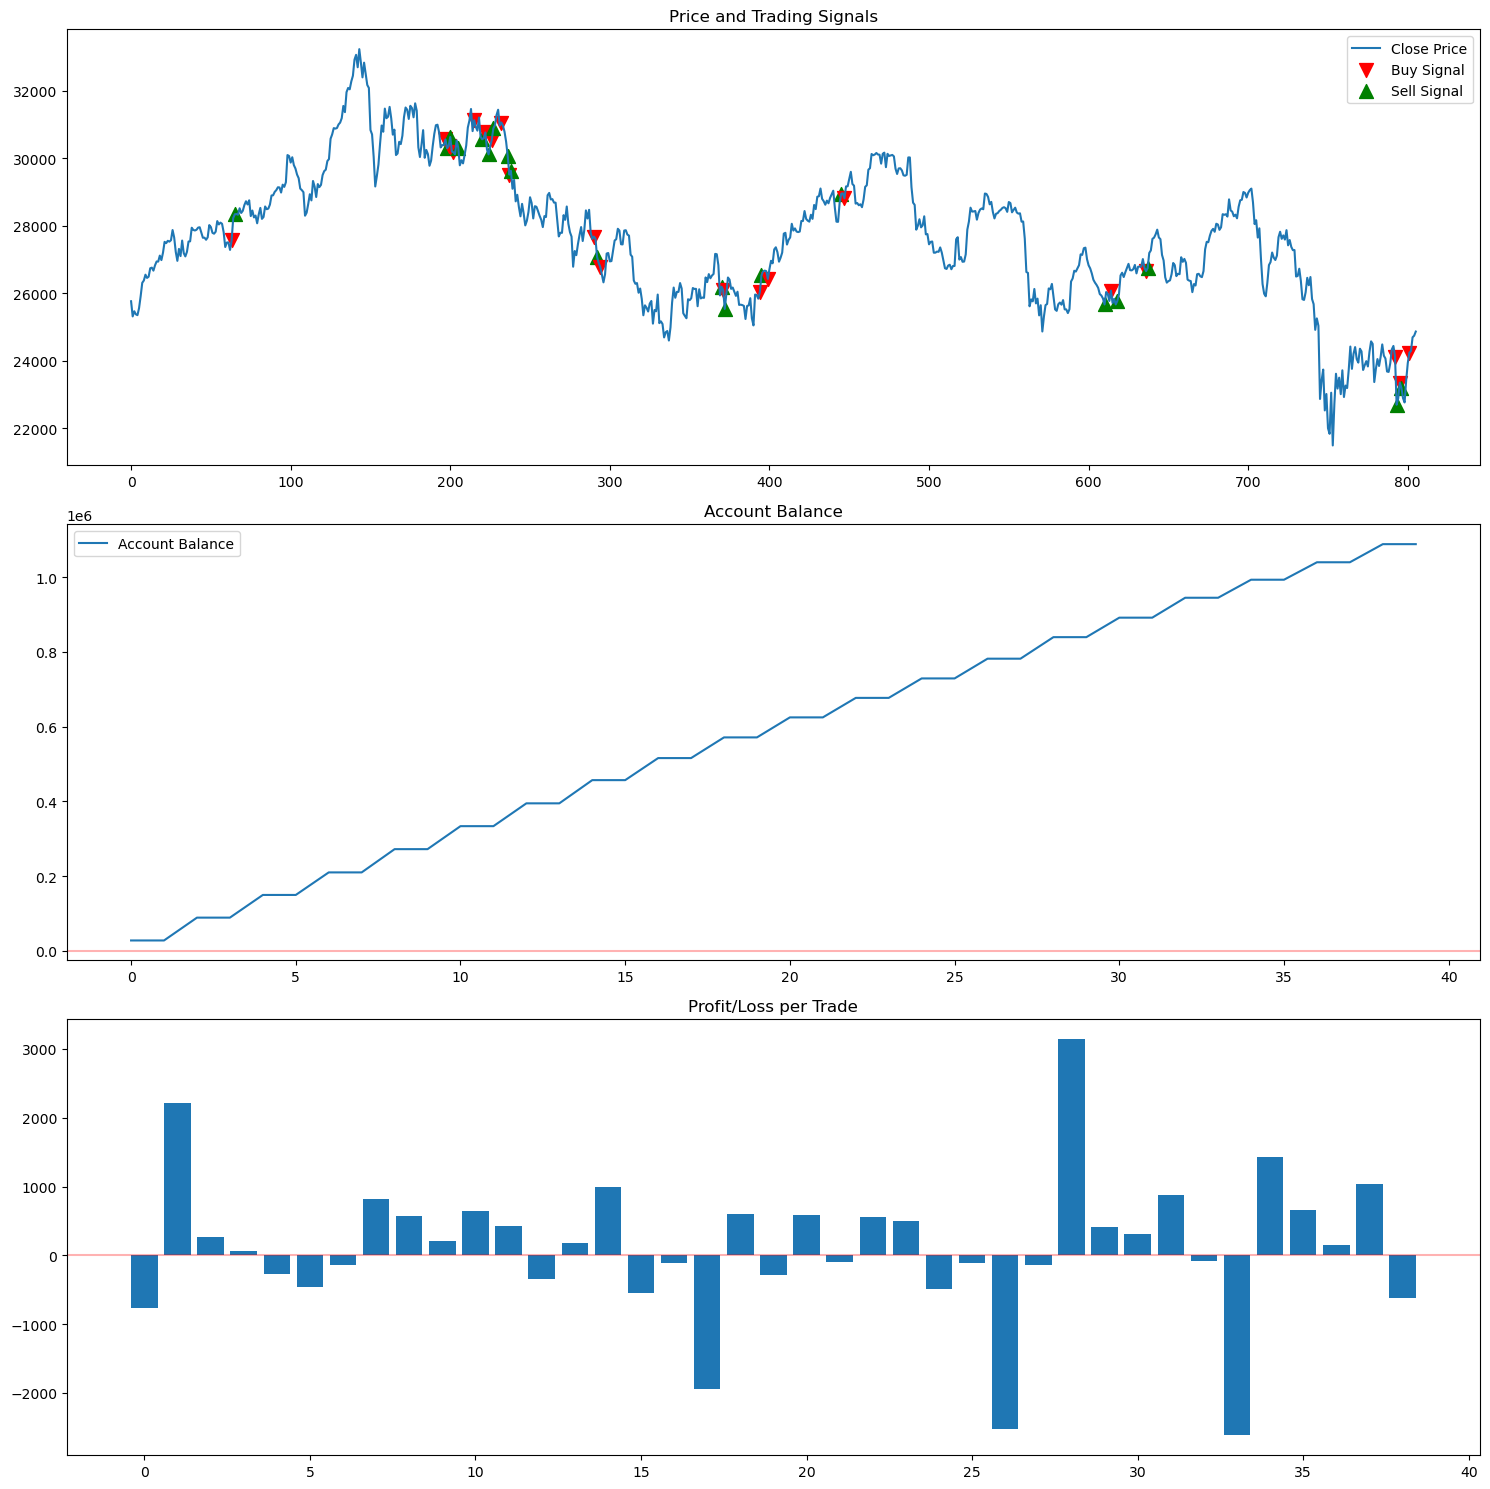

交易记录已保存至 trading_results.csv


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 读取数据并只保留每日最后一分钟的交易数据
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    # 按日期分组并获取每组的最后一行（每天的最后一分钟）
    last_minute_df = df.groupby('date').last().reset_index()
    
    print(f"原始数据行数: {len(df)}")
    print(f"处理后数据行数: {len(last_minute_df)}")
    
    return last_minute_df

# 迪基-富勒检验函数
def is_stationary(series, significance=0.05):
    result = adfuller(series)
    p_value = result[1]
    return p_value < significance  # 如果p值小于显著性水平，则拒绝原假设，认为序列是平稳的

# 交易策略实现
def arima_adf_strategy(df):
    # 初始化结果
    trades = []
    balance = 0  # 仅用于跟踪交易
    positions = []  # 1表示多头，-1表示空头，0表示无持仓
    current_position = 0
    
    # 从第61行开始（前60天用于建模）
    for i in range(60, len(df)):
        # 获取过去60天的收盘价
        past_60_close = df['hi1_close'].iloc[i-60:i].values
        current_price = df['hi1_close'].iloc[i]
        current_date = df['date'].iloc[i]
        current_time = df['time'].iloc[i]
        
        # 检查是否平稳
        if is_stationary(past_60_close):
            try:
                # 构建ARIMA(1,1,1)模型
                model = ARIMA(past_60_close, order=(1, 1, 1))
                model_fit = model.fit()
                
                # 预测下一个值
                forecast = model_fit.forecast(steps=1)[0]
                price_change_prediction = forecast - past_60_close[-1]
                
                # 交易决策
                if price_change_prediction > 0:  # 预测价格上涨
                    if current_position != 1:  # 如果当前不是多头
                        # 平掉旧仓位（如果有）
                        if current_position == -1:
                            profit = current_price  # 平空头的收益
                            balance += profit
                        
                        # 开新仓位
                        balance -= current_price  # 买入
                        current_position = 1
                        trades.append({
                            'date': current_date,
                            'time': current_time,
                            'action': 'BUY',
                            'price': current_price,
                            'balance': balance
                        })
                
                elif price_change_prediction < 0:  # 预测价格下跌
                    if current_position != -1:  # 如果当前不是空头
                        # 平掉旧仓位（如果有）
                        if current_position == 1:
                            profit = current_price  # 平多头的收益
                            balance += profit
                        
                        # 开新仓位
                        balance += current_price  # 卖出
                        current_position = -1
                        trades.append({
                            'date': current_date,
                            'time': current_time,
                            'action': 'SELL',
                            'price': current_price,
                            'balance': balance
                        })
            
            except Exception as e:
                # 如果ARIMA模型拟合失败，不进行交易
                print(f"ARIMA模型拟合失败: {e}")
                pass
        
        positions.append(current_position)
    
    # 平掉最后的持仓
    final_price = df['hi1_close'].iloc[-1]
    final_date = df['date'].iloc[-1]
    final_time = df['time'].iloc[-1]
    
    if current_position == 1:
        profit = final_price
        balance += 0 #profit
        trades.append({
            'date': final_date,
            'time': final_time,
            'action': 'CLOSE_LONG',
            'price': final_price,
            'balance': balance
        })
    elif current_position == -1:
        profit = -final_price
        balance += 0 #profit
        trades.append({
            'date': final_date,
            'time': final_time,
            'action': 'CLOSE_SHORT',
            'price': final_price,
            'balance': balance
        })
    
    # 计算策略表现
    trade_df = pd.DataFrame(trades)
    
    # 计算总收益
    total_profit = balance
    
    # 计算交易次数
    num_trades = len(trades)
    
    # 计算每笔交易的盈亏
    trade_profits = []
    if num_trades > 0:
        for i in range(1, len(trades)):
            if trades[i-1]['action'] == 'BUY' and trades[i]['action'] in ['SELL', 'CLOSE_LONG']:
                trade_profits.append(trades[i]['price'] - trades[i-1]['price'])
            elif trades[i-1]['action'] == 'SELL' and trades[i]['action'] in ['BUY', 'CLOSE_SHORT']:
                trade_profits.append(trades[i-1]['price'] - trades[i]['price'])
        
        # 计算胜率
        win_rate = sum(1 for p in trade_profits if p > 0) / len(trade_profits) * 100 if trade_profits else 0
        
        # 计算平均盈利和平均亏损
        avg_profit = np.mean([p for p in trade_profits if p > 0]) if any(p > 0 for p in trade_profits) else 0
        avg_loss = np.mean([p for p in trade_profits if p < 0]) if any(p < 0 for p in trade_profits) else 0
        
        # 计算盈亏比
        profit_loss_ratio = abs(avg_profit / avg_loss) if avg_loss != 0 else float('inf')
    else:
        win_rate = 0
        avg_profit = 0
        avg_loss = 0
        profit_loss_ratio = 0
    
    return {
        'trades': trade_df,
        'positions': positions,
        'total_profit': total_profit,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'avg_profit': avg_profit,
        'avg_loss': avg_loss,
        'profit_loss_ratio': profit_loss_ratio,
        'trade_profits': trade_profits
    }

# 可视化结果
def plot_results(df, results):
    plt.figure(figsize=(15, 15))
    
    # 绘制价格走势和交易信号
    plt.subplot(3, 1, 1)
    plt.plot(range(len(df)), df['hi1_close'], label='Close Price')
    
    # 标记交易点
    if not results['trades'].empty:
        for i, trade in results['trades'].iterrows():
            # 找到交易在原始数据中的索引
            idx = df[(df['date'] == trade['date']) & (df['time'] == trade['time'])].index
            if len(idx) > 0:
                idx = idx[0]
                if trade['action'] == 'BUY':
                    plt.scatter(idx, trade['price'], color='green', marker='^', s=100)
                elif trade['action'] == 'SELL':
                    plt.scatter(idx, trade['price'], color='red', marker='v', s=100)
    
    plt.title('Price and Trading Signals')
    plt.legend(['Close Price', 'Buy Signal', 'Sell Signal'])
    
    # 绘制账户余额
    plt.subplot(3, 1, 2)
    if not results['trades'].empty:
        plt.plot(range(len(results['trades'])), results['trades']['balance'], label='Account Balance')
    plt.title('Account Balance')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.legend()
    
    # 绘制每笔交易盈亏
    plt.subplot(3, 1, 3)
    if results['trade_profits']:
        plt.bar(range(len(results['trade_profits'])), results['trade_profits'])
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
        plt.title('Profit/Loss per Trade')
    
    plt.tight_layout()
    plt.show()

# 主函数
def main():
    file_path = 'hi1_20170701_20200609.csv'
    df = load_data(file_path)
    
    # 执行策略
    results = arima_adf_strategy(df)
    
    # 打印结果
    print(f"总获利金额: {results['total_profit']:.2f}")
    print(f"交易次数: {results['num_trades']}")
    print(f"胜率: {results['win_rate']:.2f}%")
    print(f"平均盈利: {results['avg_profit']:.2f}")
    print(f"平均亏损: {results['avg_loss']:.2f}")
    print(f"盈亏比: {results['profit_loss_ratio']:.2f}")
    
    # 可视化结果
    plot_results(df, results)
    
    # 保存交易记录
    if not results['trades'].empty:
        results['trades'].to_csv('trading_results.csv', index=False)
        print("交易记录已保存至 trading_results.csv")

if __name__ == "__main__":
    main()